# NLP

# Import Libraries

In [1]:
from pprint import pprint            # For pretty-printing data structures
from bs4 import BeautifulSoup        # Import BeautifulSoup for HTML parsing
from urllib.request import urlopen   # For opening URLs

import requests                     # For adding header
import pandas as pd
import re                           # For numeric columns
import numpy as np                  # For numeric columns

import matplotlib.pyplot as plt     # For visualization


import nltk                             # For Stopwords
import string                           # For Stopwords
from nltk.corpus import stopwords       # For Stopwords
from nltk.tokenize import word_tokenize # For Stopwords
from string import punctuation          # For Stopwords

# 1. Choose a Website and Identify Structured Data

I chose the Wikipedia website for this task. As part of my ongoing research on wildfires in the USA, I was looking for a comprehensive list of wildfire events. This website provides a well-structured table that summarizes wildfire history across the country. The table includes clearly organized information such as the year, size, the name of the wildfire, and area.  
I select this table not only because it is relevant to my research topic, but also because the HTML structure of the table is relatively simple and consistent, making it easier to scrape.  

(Ref: https://en.wikipedia.org/wiki/List_of_wildfires)

# 2. Scrape Data Using BeautifulSoup

### 2-1. Load website

In [2]:
# Target website
myurl = 'https://en.wikipedia.org/wiki/List_of_wildfires'

# Add header for avoiding error: 'HTTP Error 403: Forbidden'
# ref: https://stackoverflow.com/questions/77129954/error-403-webscraping-project-using-beautifulsoup
headers = {'User-Agent' : 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/117.0'}

# Request with header 
request_id = requests.get(myurl, 
                          headers = headers)

# Parse the HTML content using BeautifulSoup with the chosen parser
soupified = BeautifulSoup(request_id.content, 'html.parser')

### 2-2. Find all tables in the website

Extract only table including `Year`, `Size`, `Name`, and `Area`.

In [3]:
def extract_table_data(soup_object):
    tables_data = []
    
    for table_index, table in enumerate(soup_object.find_all('table')):
        table_data = []
        rows = table.find_all('tr')
        
        for row in rows:
            # Handle both header (th) and data (td) cells
            cells = row.find_all(['th', 'td'])
            row_data = [cell.get_text(strip=True) for cell in cells]
            if row_data:  # Only add non-empty rows
                table_data.append(row_data)
        
        if table_data:  # Only add non-empty tables
            tables_data.append({
                'table_index': table_index,
                'data': table_data,
                'rows': len(table_data),
                'columns': len(table_data[0]) if table_data else 0
            })
    
    return tables_data

table_info = extract_table_data(soupified)
for table in table_info:
    print(f"Table {table['table_index']}: {table['rows']} rows × {table['columns']} columns")

Table 0: 1 rows × 2 columns
Table 1: 132 rows × 5 columns
Table 2: 16 rows × 1 columns
Table 3: 5 rows × 2 columns


**Table 1** is the table I'm interested in. Therefore, I will only use Table 1.

In [4]:
# Extract Table 1 from the `table_info` variable above.
table_info[1]['data'][:3] # Show only top 3 rows

[['Year', 'Size', 'Name', 'Area', 'Notes'],
 ['1825',
  '3,000,000 acres (1,200,000\xa0ha)',
  '1825 Miramichi fire',
  'New Brunswick',
  'Killed between 160 and 300 people.'],
 ['1845',
  '1,500,000 acres (610,000\xa0ha)',
  'The Great Fire',
  'Oregon',
  '[29]']]

# 3. Clean and Organize the Data

However, I would like to extract only `Year`, `Size`, `Name`, and `Area`, so I need to drop the `Notes` column. To do this, I need to convert this list-type data into a dataframe by using Pandas.

### 3-1. Convert your parsed data into a pandas DataFrame.

In [5]:
columns = table_info[1]['data'][0]     # Choose only column names
records = table_info[1]['data'][1:]    # Choose the rest of rows

fire = pd.DataFrame(records,           # Create DataFrame
                    columns = columns)

del fire['Notes']    # Drop Notes column

print(fire.shape)    # Display the number of rows and columns
fire.head()          # Print top 5 rows

(131, 4)


,Year,Size,Name,Area
0,1825,"3,000,000 acres (1,200,000 ha)",1825 Miramichi fire,New Brunswick
1,1845,"1,500,000 acres (610,000 ha)",The Great Fire,Oregon
2,1865,"1,000,000 acres (400,000 ha)",The Silverton Fire,Oregon
3,1853,"450,000 acres (180,000 ha)",The Yaquina Fire,Oregon
4,1868,"300,000 acres (120,000 ha)",The Coos Fire,Oregon


### 3-2. Convert numeric columns (e.g., remove commas/units)

As we can see, the `Size` column represents the extent of burned area, including commas, units, and parentheses. I will keep only the numeric values representing acres, removing any additional words or extra information **by using ChatGPT-4o**.

In [6]:
cleaned_fire = fire.copy()

# The code is from Chat-gpt 4o 

def clean_size(value):
    
    if pd.isna(value):                  # Handle missing values
        return np.nan
        
    value = value.replace(',', '')      # Remove commas

    # Keep only the part before `acres`
    match = re.search(r'(\d+)', value)  # r -> Ignore all escape characters (\n, \t etc.)
    if match:                           # (\d+) -> Find all continuous numeric values greater than 1, and make it as group
        return int(match.group(1))      # Pick the first group
    else:
        return np.nan

cleaned_fire['Size'] = fire['Size']\
                        .apply(clean_size)\
                        .astype('Int64')    # Convert type of column 
cleaned_fire.head()

,Year,Size,Name,Area
0,1825,3000000,1825 Miramichi fire,New Brunswick
1,1845,1500000,The Great Fire,Oregon
2,1865,1000000,The Silverton Fire,Oregon
3,1853,450000,The Yaquina Fire,Oregon
4,1868,300000,The Coos Fire,Oregon


In [7]:
cleaned_fire.isna().sum() # Check missing values by column.

Year    0
Size    2
Name    0
Area    0
dtype: int64

In [8]:
cleaned_fire[cleaned_fire['Size'].isna()] # Check missing data are converted as Nan.

,Year,Size,Name,Area
22,1923,NaN,Giant Berkeley Fire,California
102,2016,NaN,August 2016 Western United States wildfires,"California, Idaho, Montana, Nevada, Oregon, Wa..."


### 3-3. Standardize text formats (e.g, convert to lower case)

In [9]:
# Convert the column names into lower case
cleaned_fire.columns = cleaned_fire.columns.str.lower()
cleaned_fire[['name', 'area']] = cleaned_fire[['name', 'area']].apply(lambda col: col.str.lower())

In [10]:
cleaned_fire.head()

,year,size,name,area
0,1825,3000000,1825 miramichi fire,new brunswick
1,1845,1500000,the great fire,oregon
2,1865,1000000,the silverton fire,oregon
3,1853,450000,the yaquina fire,oregon
4,1868,300000,the coos fire,oregon


I converted all column names and their values to lowercase, and simplified the size column by removing commas and unit labels to retain only the numeric area.

### 3-4. Handle missing values (e.g, fill with NaN)

In [11]:
# Need to check both `.isna()` and `str.stip() == ''`. Becuase empty '' are not detected by `.isna()`

empty = cleaned_fire['name'].str.strip() == '' # Find empty rows
print(empty)

cleaned_fire.loc[empty, 'name'] = 'Nan'        # Empty row fill with `Nan`

0      False
1      False
2      False
3      False
4      False
       ...  
126    False
127    False
128    False
129    False
130    False
Name: name, Length: 131, dtype: bool


In [12]:
cleaned_fire[10:13] # Check the result

,year,size,name,area
10,1889,300000,santiago canyon fire,california
11,1894,350000,great hinckley fire,minnesota
12,1898,2500000,Nan,south carolina


### 3-5. Remove Stopword: `and`

In such cases, it’s not enough to simply remove 'and', there are instances like 'idaho andmontana' where 'and' is attached to a state name. To handle these cases properly, I referred to code examples using **ChatGPT-4o**.

In [13]:
nltk.download('stopwords') # download for stopwords
nltk.download('punkt_tab')

def preprocess_corpus(texts):
    
    # Load English stopwords once for efficiency
    mystopwords = set(stopwords.words("english"))
    
    def remove_stops(text):
        text = re.sub(r'and', ' ', text) # Split in cases like 'idahoandmontana' where 'and' and state names are stuck together

        tokens = word_tokenize(text)     # Make token based on ' ' 

        cleaned = [t for t in tokens if t not in mystopwords and t.strip() != '']

        return '_'.join(cleaned) # Connect with '_'
        
    # Tokenize and clean each text in the input list
    return [remove_stops(str(t)) for t in texts]
    

cleaned_tokens = preprocess_corpus(cleaned_fire['area'].tolist()) # Put area column as a type of list
cleaned_tokens[:15]

[nltk_data] Downloading package stopwords to /home/jlc3q/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jlc3q/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


['new_brunswick',
 'oregon',
 'oregon',
 'oregon',
 'oregon',
 'quebec',
 'wisconsin',
 'michigan',
 'wyoming',
 'michigan',
 'california',
 'minnesota',
 'south_carolina',
 'washington_oregon',
 'new_york']

In [14]:
cleaned_fire['new_area'] = cleaned_tokens 
cleaned_fire.head()

,year,size,name,area,new_area
0,1825,3000000,1825 miramichi fire,new brunswick,new_brunswick
1,1845,1500000,the great fire,oregon,oregon
2,1865,1000000,the silverton fire,oregon,oregon
3,1853,450000,the yaquina fire,oregon,oregon
4,1868,300000,the coos fire,oregon,oregon


In [15]:
cleaned_fire.head(20) # Check the special cases: 16, 19 rows

,year,size,name,area,new_area
0,1825,3000000,1825 miramichi fire,new brunswick,new_brunswick
1,1845,1500000,the great fire,oregon,oregon
2,1865,1000000,the silverton fire,oregon,oregon
3,1853,450000,the yaquina fire,oregon,oregon
4,1868,300000,the coos fire,oregon,oregon
5,1870,964000,saguenay fire,quebec,quebec
6,1871,1200000,peshtigo fire,wisconsin,wisconsin
7,1871,2500000,great michigan fire,michigan,michigan
8,1876,500000,bighorn fire,wyoming,wyoming
9,1881,1000000,thumb fire,michigan,michigan


I removed 'and' as well as instances where 'and' was attached to other words, and then connected the remaining parts using underscores '_'.

# 4. Simple Data Analysis or Visualization (2 points)

### 4-1. Sort and display top items in a category

In [16]:
print("Subset the top 3 most frequent areas:\n", cleaned_fire.new_area.value_counts().head(), '\n')

top5_areas = cleaned_fire.new_area.value_counts().head().index     # Extract only top 5 area names
print("Extracted Top 5 Areas:\n", top5_areas)

Subset the top 3 most frequent areas:
 california          31
british_columbia     9
oregon               9
colorado             8
new_mexico           6
Name: new_area, dtype: int64 

Extracted Top 5 Areas:
 Index(['california', 'british_columbia', 'oregon', 'colorado', 'new_mexico'], dtype='object')


In [17]:
cleaned_fire[cleaned_fire['new_area'].isin(top5_areas)].head()  # Take a look into top5_areas

,year,size,name,area,new_area
1,1845,1500000,the great fire,oregon,oregon
2,1865,1000000,the silverton fire,oregon,oregon
3,1853,450000,the yaquina fire,oregon,oregon
4,1868,300000,the coos fire,oregon,oregon
10,1889,300000,santiago canyon fire,california,california


### 4-2. Calculate averages/sums of numeric columns

In [18]:
# Filter for the top 3 areas, sum the sizes, and sort the results

subset_areas = cleaned_fire[cleaned_fire['new_area']\
                                    .isin(top5_areas)]\
                                    .groupby('new_area')['size']\
                                    .mean()\
                                    .sort_values(ascending = False)
subset_areas

new_area
british_columbia    817624.222222
oregon              656690.333333
california          389176.233333
new_mexico          161928.666667
colorado            124832.875000
Name: size, dtype: float64

### 4-3. Create a bar chart or pie chart to compare categories using matplotlib or seaborn

Average of top 5 areas: 430050.0 2


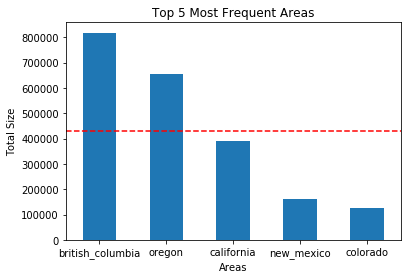

In [19]:
# Histogram
subset_areas.plot(kind = 'bar')

plt.xlabel('Areas')         # X label
plt.ylabel('Total Size')    # Y label

plt.xticks(rotation = 0)    # Adjust x label angles

plt.title('Top 5 Most Frequent Areas') # Title

total_average = subset_areas.mean()    # Add top 5 areas' average

print("Average of top 5 areas:", round(total_average), 2)

plt.axhline(y = total_average,         # Threshold line
            color = 'red', 
            linestyle = '--')

plt.show() # Result

An interesting observation is that British Columbia experienced 9 wildfires, the same number as Oregon, and second only to California, which had 31 incidents.
However, when looking at the average area burned per wildfire by area in the histogram, we can see that British Columbia had the largest average burned area, despite having fewer fires.

In contrast, California, which had the overwhelming number of wildfires, shows a relatively low average area burned per fire, even below the red line indicating the average among the top 5 areas.
This suggests that California experiences frequent but relatively small-scale wildfires.

Alternatively, it could indicate that British Columbia has less effective wildfire containment, leading to more severe damage per incident compared to Oregon or California.

# 5. Reflection and Extension

**What challenges did you face compared to the basic example?**  

- It was an unexpected case where “and” was attached to other words. I hadn’t anticipated that “and” could appear without spaces, and when dealing with a large amount of data, such cases can easily be overlooked. In my case, I discovered it during the analysis and was able to resolve it with the help of ChatGPT. However, since this situation isn’t typically covered in basic examples, it was quite a challenging issue to handle.

**Are there other Python packages (like Scrapy or Selenium) that might help if the site was more complex?**  

- I definitely believe it would be helpful. In my case, I worked with a relatively simple table structure from Wikipedia, but I’m sure there are websites with much more complex layouts. In those situations, I think tools like Scrapy or Selenium would be very useful.

**Suggest one AI prompt you could use with Copilot to help automate or improve your code (e.g., “Generate code to handle pagination in BeautifulSoup”).**  

- I want to clean the area column by removing the stopword “and”. The issue is that sometimes “and” is properly spaced, like in “washington and oregon”, but other times it’s stuck to other words, like “idahoandmontana”. I want to remove “and” in both cases and then connect the remaining words with underscores, so for example, “new brunswick” becomes “new_brunswick”, and “idahoandmontana” becomes “idaho_montana”.
